# Convolutional Autoencoder

Sticking with the MNIST dataset, let's improve our autoencoder's performance using convolutional layers. Again, loading modules and the data.

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tqdm 

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', validation_size=0)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


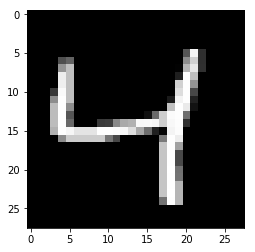

In [3]:
img = mnist.train.images[2]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

## Network Architecture

The encoder part of the network will be a typical convolutional pyramid. Each convolutional layer will be followed by a max-pooling layer to reduce the dimensions of the layers. The decoder though might be something new to you. The decoder needs to convert from a narrow representation to a wide reconstructed image. For example, the representation could be a 4x4x8 max-pool layer. This is the output of the encoder, but also the input to the decoder. We want to get a 28x28x1 image out from the decoder so we need to work our way back up from the narrow decoder input layer. A schematic of the network is shown below.

<img src='assets/convolutional_autoencoder.png' width=500px>

Here our final encoder layer has size 4x4x8 = 128. The original images have size 28x28 = 784, so the encoded vector is roughly 16% the size of the original image. These are just suggested sizes for each of the layers. Feel free to change the depths and sizes, but remember our goal here is to find a small representation of the input data.

### What's going on with the decoder

Okay, so the decoder has these "Upsample" layers that you might not have seen before. First off, I'll discuss a bit what these layers *aren't*. Usually, you'll see **transposed convolution** layers used to increase the width and height of the layers. They work almost exactly the same as convolutional layers, but in reverse. A stride in the input layer results in a larger stride in the transposed convolution layer. For example, if you have a 3x3 kernel, a 3x3 patch in the input layer will be reduced to one unit in a convolutional layer. Comparatively, one unit in the input layer will be expanded to a 3x3 path in a transposed convolution layer. The TensorFlow API provides us with an easy way to create the layers, [`tf.nn.conv2d_transpose`](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). 

However, transposed convolution layers can lead to artifacts in the final images, such as checkerboard patterns. This is due to overlap in the kernels which can be avoided by setting the stride and kernel size equal. In [this Distill article](http://distill.pub/2016/deconv-checkerboard/) from Augustus Odena, *et al*, the authors show that these checkerboard artifacts can be avoided by resizing the layers using nearest neighbor or bilinear interpolation (upsampling) followed by a convolutional layer. In TensorFlow, this is easily done with [`tf.image.resize_images`](https://www.tensorflow.org/versions/r1.1/api_docs/python/tf/image/resize_images), followed by a convolution. Be sure to read the Distill article to get a better understanding of deconvolutional layers and why we're using upsampling.

> **Exercise:** Build the network shown above. Remember that a convolutional layer with strides of 1 and 'same' padding won't reduce the height and width. That is, if the input is 28x28 and the convolution layer has stride = 1 and 'same' padding, the convolutional layer will also be 28x28. The max-pool layers are used the reduce the width and height. A stride of 2 will reduce the size by a factor of 2. Odena *et al* claim that nearest neighbor interpolation works best for the upsampling, so make sure to include that as a parameter in `tf.image.resize_images` or use [`tf.image.resize_nearest_neighbor`]( `https://www.tensorflow.org/api_docs/python/tf/image/resize_nearest_neighbor). For convolutional layers, use [`tf.layers.conv2d`](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d). For example, you would write `conv1 = tf.layers.conv2d(inputs, 32, (5,5), padding='same', activation=tf.nn.relu)` for a layer with a depth of 32, a 5x5 kernel, stride of (1,1), padding is 'same', and a ReLU activation. Similarly, for the max-pool layers, use [`tf.layers.max_pooling2d`](https://www.tensorflow.org/api_docs/python/tf/layers/max_pooling2d).

In [4]:
def conv_maxpool(x_tensor,conv_output_size,conv_ksize,conv_strides,pool_ksize,pool_strides):
    # Shape of the tensor
    shape_tensor = x_tensor.get_shape().as_list()
    
    #Weight and bias dimensions 
    weight_dim = [*conv_ksize,shape_tensor[-1],conv_output_size]
    bias_dim = [conv_output_size]
    
    #Pool and stride dimensions
    ksize = [1,*pool_ksize,1]
    stride = {"conv" : [1,*conv_strides,1], "pool" : [1,*pool_strides,1]}
    
    weights = tf.Variable(tf.truncated_normal(mean=0, stddev=0.1,shape=weight_dim))
    biases = tf.constant(0.1,shape=(bias_dim))
    
    ## Convolution ##
    conv_layer = tf.nn.bias_add(tf.nn.conv2d(x_tensor,weights,stride["conv"],padding="SAME"), biases)
    
    ## Activation
    conv_layer = tf.nn.relu(conv_layer)
    
    ## Max Pooling ##
    conv_layer = tf.nn.max_pool(conv_layer,ksize,stride["pool"],padding="SAME")
    
    return conv_layer

def resize_conv(x_tensor,conv_output_size,conv_ksize,conv_strides,resize_size):
    # Shape of the tensor
    shape_tensor = x_tensor.get_shape().as_list()
    
    # Weight and bias dimensions
    weight_dim = [*conv_ksize,shape_tensor[-1],conv_output_size]
    bias_dim = [conv_output_size]
    
    # Weight and Biases
    weights = tf.Variable(tf.truncated_normal(mean=0, stddev=0.1,shape=weight_dim))
    biases = tf.constant(0.1,shape=(bias_dim))
    
    ## Resizing the image ##
    resize_layer = tf.image.resize_nearest_neighbor(x_tensor, [*resize_size])
    
    ## Padding the image ##
    pad = "SAME"
    
    ## Convolution ##
    resize_layer = tf.nn.bias_add(tf.nn.conv2d(resize_layer,weights,[1,*conv_strides,1],padding=pad),biases)
    
    ## Acitvation ##
    resize_layer = tf.nn.relu(resize_layer)
    
    return resize_layer

def output_layer(x_tensor,conv_output_size,conv_ksize,conv_strides):
    # Shape of tensor 
    shape_tensor = x_tensor.get_shape().as_list()
    
    # Weight and Bias Dimension
    # Weight and bias dimensions
    weight_dim = [*conv_ksize,shape_tensor[-1],conv_output_size]
    bias_dim = [conv_output_size]
    
    # Weight and Biases
    weights = tf.Variable(tf.truncated_normal(mean=0, stddev=0.1,shape=weight_dim))
    biases = tf.constant(0.1,shape=(bias_dim))
    
    ## Convolution ##
    conv_layer = tf.nn.conv2d(x_tensor,weights,[1,*conv_strides,1],padding="SAME")
    
    return conv_layer

In [4]:
learning_rate = 0.001
# Input and target placeholders
input_ = tf.placeholder(tf.float32,shape=[None,28,28,1])
targets_ = tf.placeholder(tf.float32,shape=[None,28,28,1])

### Encoder
conv1_maxpool = conv_maxpool(input_,16,(3,3),(1,1),(2,2),(2,2))
# Now 14x14x16
conv2_maxpool = conv_maxpool(conv1_maxpool,8,(3,3),(1,1),(2,2),(2,2)) 
# Now 7x7x8
conv3_maxpool = conv_maxpool(conv2_maxpool,8,(3,3),(1,1),(2,2),(2,2))
# Now 4x4x8
encoded = conv3_maxpool
# Now 4x4x8

### Decoder
upsample1_conv = resize_conv(encoded,8,(3,3),(1,1),(7,7))
# Now 7x7x8
upsample2_conv = resize_conv(upsample1_conv,8,(3,3),(1,1),(14,14))
# Now 14x14x8
upsample3_conv = resize_conv(upsample2_conv,16,(3,3),(1,1),(28,28))
# Now 28x28x16
logits = output_layer(upsample3_conv,1,(3,3),(1,1))
#Now 28x28x1

# Pass logits through sigmoid to get reconstructed image
decoded = tf.nn.sigmoid(logits)

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=targets_)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

## Training

As before, here we'll train the network. Instead of flattening the images though, we can pass them in as 28x28x1 arrays.

In [5]:
sess = tf.Session()

In [6]:
epochs = 20
batch_size = 200
sess.run(tf.global_variables_initializer())
for e in tqdm.tqdm(range(epochs)):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        imgs = batch[0].reshape((-1, 28, 28, 1))
        batch_cost, _ = sess.run([cost, opt], feed_dict={input_: imgs,
                                                         targets_: imgs})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1/20... Training loss: 0.6838
Epoch: 1/20... Training loss: 0.6704
Epoch: 1/20... Training loss: 0.6578
Epoch: 1/20... Training loss: 0.6459
Epoch: 1/20... Training loss: 0.6326
Epoch: 1/20... Training loss: 0.6193
Epoch: 1/20... Training loss: 0.6044
Epoch: 1/20... Training loss: 0.5851
Epoch: 1/20... Training loss: 0.5732
Epoch: 1/20... Training loss: 0.5524
Epoch: 1/20... Training loss: 0.5355
Epoch: 1/20... Training loss: 0.5167
Epoch: 1/20... Training loss: 0.4970
Epoch: 1/20... Training loss: 0.4774
Epoch: 1/20... Training loss: 0.4825
Epoch: 1/20... Training loss: 0.4771
Epoch: 1/20... Training loss: 0.4921
Epoch: 1/20... Training loss: 0.4879
Epoch: 1/20... Training loss: 0.4846
Epoch: 1/20... Training loss: 0.4867
Epoch: 1/20... Training loss: 0.4687
Epoch: 1/20... Training loss: 0.4747
Epoch: 1/20... Training loss: 0.4664
Epoch: 1/20... Training loss: 0.4576
Epoch: 1/20... Training loss: 0.4486
Epoch: 1/20... Training loss: 0.4583
Epoch: 1/20... Training loss: 0.4570
E

Epoch: 1/20... Training loss: 0.1709
Epoch: 1/20... Training loss: 0.1764
Epoch: 1/20... Training loss: 0.1664
Epoch: 1/20... Training loss: 0.1677
Epoch: 1/20... Training loss: 0.1611
Epoch: 1/20... Training loss: 0.1629
Epoch: 1/20... Training loss: 0.1678
Epoch: 1/20... Training loss: 0.1694
Epoch: 1/20... Training loss: 0.1673
Epoch: 1/20... Training loss: 0.1641
Epoch: 1/20... Training loss: 0.1696
Epoch: 1/20... Training loss: 0.1570
Epoch: 1/20... Training loss: 0.1637
Epoch: 1/20... Training loss: 0.1599
Epoch: 1/20... Training loss: 0.1646
Epoch: 1/20... Training loss: 0.1696
Epoch: 1/20... Training loss: 0.1607
Epoch: 1/20... Training loss: 0.1640
Epoch: 1/20... Training loss: 0.1605
Epoch: 1/20... Training loss: 0.1584
Epoch: 1/20... Training loss: 0.1618
Epoch: 1/20... Training loss: 0.1630
Epoch: 1/20... Training loss: 0.1620
Epoch: 1/20... Training loss: 0.1650
Epoch: 1/20... Training loss: 0.1656
Epoch: 1/20... Training loss: 0.1603
Epoch: 1/20... Training loss: 0.1630
E

  5%|▌         | 1/20 [01:26<27:31, 86.92s/it]

Epoch: 1/20... Training loss: 0.1545
Epoch: 2/20... Training loss: 0.1601
Epoch: 2/20... Training loss: 0.1542
Epoch: 2/20... Training loss: 0.1465
Epoch: 2/20... Training loss: 0.1576
Epoch: 2/20... Training loss: 0.1518
Epoch: 2/20... Training loss: 0.1540
Epoch: 2/20... Training loss: 0.1510
Epoch: 2/20... Training loss: 0.1518
Epoch: 2/20... Training loss: 0.1561
Epoch: 2/20... Training loss: 0.1518
Epoch: 2/20... Training loss: 0.1475
Epoch: 2/20... Training loss: 0.1492
Epoch: 2/20... Training loss: 0.1529
Epoch: 2/20... Training loss: 0.1516
Epoch: 2/20... Training loss: 0.1542
Epoch: 2/20... Training loss: 0.1469
Epoch: 2/20... Training loss: 0.1498
Epoch: 2/20... Training loss: 0.1541
Epoch: 2/20... Training loss: 0.1537
Epoch: 2/20... Training loss: 0.1500
Epoch: 2/20... Training loss: 0.1549
Epoch: 2/20... Training loss: 0.1486
Epoch: 2/20... Training loss: 0.1484
Epoch: 2/20... Training loss: 0.1510
Epoch: 2/20... Training loss: 0.1418
Epoch: 2/20... Training loss: 0.1505
E

Epoch: 2/20... Training loss: 0.1327
Epoch: 2/20... Training loss: 0.1311
Epoch: 2/20... Training loss: 0.1363
Epoch: 2/20... Training loss: 0.1352
Epoch: 2/20... Training loss: 0.1315
Epoch: 2/20... Training loss: 0.1266
Epoch: 2/20... Training loss: 0.1304
Epoch: 2/20... Training loss: 0.1313
Epoch: 2/20... Training loss: 0.1343
Epoch: 2/20... Training loss: 0.1292
Epoch: 2/20... Training loss: 0.1294
Epoch: 2/20... Training loss: 0.1335
Epoch: 2/20... Training loss: 0.1367
Epoch: 2/20... Training loss: 0.1313
Epoch: 2/20... Training loss: 0.1348
Epoch: 2/20... Training loss: 0.1341
Epoch: 2/20... Training loss: 0.1345
Epoch: 2/20... Training loss: 0.1289
Epoch: 2/20... Training loss: 0.1353
Epoch: 2/20... Training loss: 0.1313
Epoch: 2/20... Training loss: 0.1344
Epoch: 2/20... Training loss: 0.1371
Epoch: 2/20... Training loss: 0.1316
Epoch: 2/20... Training loss: 0.1317
Epoch: 2/20... Training loss: 0.1321
Epoch: 2/20... Training loss: 0.1324
Epoch: 2/20... Training loss: 0.1347
E

 10%|█         | 2/20 [02:53<26:04, 86.90s/it]

Epoch: 2/20... Training loss: 0.1347
Epoch: 3/20... Training loss: 0.1336
Epoch: 3/20... Training loss: 0.1299
Epoch: 3/20... Training loss: 0.1323
Epoch: 3/20... Training loss: 0.1275
Epoch: 3/20... Training loss: 0.1271
Epoch: 3/20... Training loss: 0.1322
Epoch: 3/20... Training loss: 0.1306
Epoch: 3/20... Training loss: 0.1299
Epoch: 3/20... Training loss: 0.1261
Epoch: 3/20... Training loss: 0.1279
Epoch: 3/20... Training loss: 0.1296
Epoch: 3/20... Training loss: 0.1267
Epoch: 3/20... Training loss: 0.1259
Epoch: 3/20... Training loss: 0.1250
Epoch: 3/20... Training loss: 0.1269
Epoch: 3/20... Training loss: 0.1268
Epoch: 3/20... Training loss: 0.1285
Epoch: 3/20... Training loss: 0.1258
Epoch: 3/20... Training loss: 0.1285
Epoch: 3/20... Training loss: 0.1292
Epoch: 3/20... Training loss: 0.1299
Epoch: 3/20... Training loss: 0.1318
Epoch: 3/20... Training loss: 0.1275
Epoch: 3/20... Training loss: 0.1242
Epoch: 3/20... Training loss: 0.1231
Epoch: 3/20... Training loss: 0.1298
E

Epoch: 3/20... Training loss: 0.1244
Epoch: 3/20... Training loss: 0.1216
Epoch: 3/20... Training loss: 0.1284
Epoch: 3/20... Training loss: 0.1235
Epoch: 3/20... Training loss: 0.1253
Epoch: 3/20... Training loss: 0.1222
Epoch: 3/20... Training loss: 0.1216
Epoch: 3/20... Training loss: 0.1217
Epoch: 3/20... Training loss: 0.1233
Epoch: 3/20... Training loss: 0.1226
Epoch: 3/20... Training loss: 0.1248
Epoch: 3/20... Training loss: 0.1239
Epoch: 3/20... Training loss: 0.1241
Epoch: 3/20... Training loss: 0.1262
Epoch: 3/20... Training loss: 0.1231
Epoch: 3/20... Training loss: 0.1270
Epoch: 3/20... Training loss: 0.1195
Epoch: 3/20... Training loss: 0.1240
Epoch: 3/20... Training loss: 0.1219
Epoch: 3/20... Training loss: 0.1214
Epoch: 3/20... Training loss: 0.1183
Epoch: 3/20... Training loss: 0.1254
Epoch: 3/20... Training loss: 0.1234
Epoch: 3/20... Training loss: 0.1230
Epoch: 3/20... Training loss: 0.1214
Epoch: 3/20... Training loss: 0.1223
Epoch: 3/20... Training loss: 0.1175
E

 15%|█▌        | 3/20 [04:23<24:53, 87.88s/it]

Epoch: 3/20... Training loss: 0.1171
Epoch: 4/20... Training loss: 0.1182
Epoch: 4/20... Training loss: 0.1183
Epoch: 4/20... Training loss: 0.1210
Epoch: 4/20... Training loss: 0.1207
Epoch: 4/20... Training loss: 0.1265
Epoch: 4/20... Training loss: 0.1234
Epoch: 4/20... Training loss: 0.1239
Epoch: 4/20... Training loss: 0.1225
Epoch: 4/20... Training loss: 0.1224
Epoch: 4/20... Training loss: 0.1280
Epoch: 4/20... Training loss: 0.1237
Epoch: 4/20... Training loss: 0.1221
Epoch: 4/20... Training loss: 0.1245
Epoch: 4/20... Training loss: 0.1171
Epoch: 4/20... Training loss: 0.1218
Epoch: 4/20... Training loss: 0.1198
Epoch: 4/20... Training loss: 0.1200
Epoch: 4/20... Training loss: 0.1194
Epoch: 4/20... Training loss: 0.1221
Epoch: 4/20... Training loss: 0.1215
Epoch: 4/20... Training loss: 0.1206
Epoch: 4/20... Training loss: 0.1310
Epoch: 4/20... Training loss: 0.1194
Epoch: 4/20... Training loss: 0.1213
Epoch: 4/20... Training loss: 0.1225
Epoch: 4/20... Training loss: 0.1196
E

Epoch: 4/20... Training loss: 0.1210
Epoch: 4/20... Training loss: 0.1213
Epoch: 4/20... Training loss: 0.1185
Epoch: 4/20... Training loss: 0.1201
Epoch: 4/20... Training loss: 0.1205
Epoch: 4/20... Training loss: 0.1186
Epoch: 4/20... Training loss: 0.1149
Epoch: 4/20... Training loss: 0.1195
Epoch: 4/20... Training loss: 0.1182
Epoch: 4/20... Training loss: 0.1219
Epoch: 4/20... Training loss: 0.1138
Epoch: 4/20... Training loss: 0.1185
Epoch: 4/20... Training loss: 0.1171
Epoch: 4/20... Training loss: 0.1150
Epoch: 4/20... Training loss: 0.1205
Epoch: 4/20... Training loss: 0.1149
Epoch: 4/20... Training loss: 0.1141
Epoch: 4/20... Training loss: 0.1145
Epoch: 4/20... Training loss: 0.1123
Epoch: 4/20... Training loss: 0.1219
Epoch: 4/20... Training loss: 0.1147
Epoch: 4/20... Training loss: 0.1147
Epoch: 4/20... Training loss: 0.1151
Epoch: 4/20... Training loss: 0.1141
Epoch: 4/20... Training loss: 0.1166
Epoch: 4/20... Training loss: 0.1219
Epoch: 4/20... Training loss: 0.1148
E

 20%|██        | 4/20 [06:21<25:46, 96.68s/it]

Epoch: 4/20... Training loss: 0.1158
Epoch: 5/20... Training loss: 0.1130
Epoch: 5/20... Training loss: 0.1210
Epoch: 5/20... Training loss: 0.1083
Epoch: 5/20... Training loss: 0.1176
Epoch: 5/20... Training loss: 0.1179
Epoch: 5/20... Training loss: 0.1164
Epoch: 5/20... Training loss: 0.1181
Epoch: 5/20... Training loss: 0.1204
Epoch: 5/20... Training loss: 0.1184
Epoch: 5/20... Training loss: 0.1160
Epoch: 5/20... Training loss: 0.1221
Epoch: 5/20... Training loss: 0.1170
Epoch: 5/20... Training loss: 0.1185
Epoch: 5/20... Training loss: 0.1190
Epoch: 5/20... Training loss: 0.1168
Epoch: 5/20... Training loss: 0.1136
Epoch: 5/20... Training loss: 0.1169
Epoch: 5/20... Training loss: 0.1208
Epoch: 5/20... Training loss: 0.1167
Epoch: 5/20... Training loss: 0.1217
Epoch: 5/20... Training loss: 0.1169
Epoch: 5/20... Training loss: 0.1233
Epoch: 5/20... Training loss: 0.1174
Epoch: 5/20... Training loss: 0.1167
Epoch: 5/20... Training loss: 0.1203
Epoch: 5/20... Training loss: 0.1177
E

Epoch: 5/20... Training loss: 0.1128
Epoch: 5/20... Training loss: 0.1110
Epoch: 5/20... Training loss: 0.1097
Epoch: 5/20... Training loss: 0.1121
Epoch: 5/20... Training loss: 0.1127
Epoch: 5/20... Training loss: 0.1119
Epoch: 5/20... Training loss: 0.1137
Epoch: 5/20... Training loss: 0.1197
Epoch: 5/20... Training loss: 0.1148
Epoch: 5/20... Training loss: 0.1115
Epoch: 5/20... Training loss: 0.1140
Epoch: 5/20... Training loss: 0.1085
Epoch: 5/20... Training loss: 0.1142
Epoch: 5/20... Training loss: 0.1118
Epoch: 5/20... Training loss: 0.1175
Epoch: 5/20... Training loss: 0.1180
Epoch: 5/20... Training loss: 0.1156
Epoch: 5/20... Training loss: 0.1141
Epoch: 5/20... Training loss: 0.1155
Epoch: 5/20... Training loss: 0.1128
Epoch: 5/20... Training loss: 0.1132
Epoch: 5/20... Training loss: 0.1111
Epoch: 5/20... Training loss: 0.1160
Epoch: 5/20... Training loss: 0.1191
Epoch: 5/20... Training loss: 0.1076
Epoch: 5/20... Training loss: 0.1158
Epoch: 5/20... Training loss: 0.1121
E

 25%|██▌       | 5/20 [08:17<25:39, 102.65s/it]

Epoch: 5/20... Training loss: 0.1113
Epoch: 6/20... Training loss: 0.1136
Epoch: 6/20... Training loss: 0.1129
Epoch: 6/20... Training loss: 0.1145
Epoch: 6/20... Training loss: 0.1133
Epoch: 6/20... Training loss: 0.1116
Epoch: 6/20... Training loss: 0.1193
Epoch: 6/20... Training loss: 0.1115
Epoch: 6/20... Training loss: 0.1081
Epoch: 6/20... Training loss: 0.1184
Epoch: 6/20... Training loss: 0.1121
Epoch: 6/20... Training loss: 0.1088
Epoch: 6/20... Training loss: 0.1129
Epoch: 6/20... Training loss: 0.1078
Epoch: 6/20... Training loss: 0.1121
Epoch: 6/20... Training loss: 0.1153
Epoch: 6/20... Training loss: 0.1130
Epoch: 6/20... Training loss: 0.1181
Epoch: 6/20... Training loss: 0.1145
Epoch: 6/20... Training loss: 0.1135
Epoch: 6/20... Training loss: 0.1143
Epoch: 6/20... Training loss: 0.1151
Epoch: 6/20... Training loss: 0.1193
Epoch: 6/20... Training loss: 0.1096
Epoch: 6/20... Training loss: 0.1117
Epoch: 6/20... Training loss: 0.1158
Epoch: 6/20... Training loss: 0.1128
E

Epoch: 6/20... Training loss: 0.1121
Epoch: 6/20... Training loss: 0.1131
Epoch: 6/20... Training loss: 0.1105
Epoch: 6/20... Training loss: 0.1119
Epoch: 6/20... Training loss: 0.1095
Epoch: 6/20... Training loss: 0.1124
Epoch: 6/20... Training loss: 0.1111
Epoch: 6/20... Training loss: 0.1095
Epoch: 6/20... Training loss: 0.1065
Epoch: 6/20... Training loss: 0.1111
Epoch: 6/20... Training loss: 0.1103
Epoch: 6/20... Training loss: 0.1137
Epoch: 6/20... Training loss: 0.1114
Epoch: 6/20... Training loss: 0.1078
Epoch: 6/20... Training loss: 0.1098
Epoch: 6/20... Training loss: 0.1108
Epoch: 6/20... Training loss: 0.1105
Epoch: 6/20... Training loss: 0.1105
Epoch: 6/20... Training loss: 0.1121
Epoch: 6/20... Training loss: 0.1058
Epoch: 6/20... Training loss: 0.1088
Epoch: 6/20... Training loss: 0.1115
Epoch: 6/20... Training loss: 0.1097
Epoch: 6/20... Training loss: 0.1117
Epoch: 6/20... Training loss: 0.1064
Epoch: 6/20... Training loss: 0.1127
Epoch: 6/20... Training loss: 0.1095
E

 30%|███       | 6/20 [10:16<25:03, 107.38s/it]

Epoch: 6/20... Training loss: 0.1113
Epoch: 7/20... Training loss: 0.1079
Epoch: 7/20... Training loss: 0.1073
Epoch: 7/20... Training loss: 0.1109
Epoch: 7/20... Training loss: 0.1087
Epoch: 7/20... Training loss: 0.1109
Epoch: 7/20... Training loss: 0.1129
Epoch: 7/20... Training loss: 0.1115
Epoch: 7/20... Training loss: 0.1133
Epoch: 7/20... Training loss: 0.1155
Epoch: 7/20... Training loss: 0.1083
Epoch: 7/20... Training loss: 0.1056
Epoch: 7/20... Training loss: 0.1101
Epoch: 7/20... Training loss: 0.1120
Epoch: 7/20... Training loss: 0.1128
Epoch: 7/20... Training loss: 0.1090
Epoch: 7/20... Training loss: 0.1056
Epoch: 7/20... Training loss: 0.1113
Epoch: 7/20... Training loss: 0.1106
Epoch: 7/20... Training loss: 0.1080
Epoch: 7/20... Training loss: 0.1058
Epoch: 7/20... Training loss: 0.1092
Epoch: 7/20... Training loss: 0.1132
Epoch: 7/20... Training loss: 0.1093
Epoch: 7/20... Training loss: 0.1104
Epoch: 7/20... Training loss: 0.1117
Epoch: 7/20... Training loss: 0.1113
E

Epoch: 7/20... Training loss: 0.1100
Epoch: 7/20... Training loss: 0.1068
Epoch: 7/20... Training loss: 0.1078
Epoch: 7/20... Training loss: 0.1088
Epoch: 7/20... Training loss: 0.1098
Epoch: 7/20... Training loss: 0.1087
Epoch: 7/20... Training loss: 0.1112
Epoch: 7/20... Training loss: 0.1056
Epoch: 7/20... Training loss: 0.1084
Epoch: 7/20... Training loss: 0.1075
Epoch: 7/20... Training loss: 0.1104
Epoch: 7/20... Training loss: 0.1078
Epoch: 7/20... Training loss: 0.1102
Epoch: 7/20... Training loss: 0.1101
Epoch: 7/20... Training loss: 0.1077
Epoch: 7/20... Training loss: 0.1077
Epoch: 7/20... Training loss: 0.1096
Epoch: 7/20... Training loss: 0.1129
Epoch: 7/20... Training loss: 0.1106
Epoch: 7/20... Training loss: 0.1091
Epoch: 7/20... Training loss: 0.1093
Epoch: 7/20... Training loss: 0.1063
Epoch: 7/20... Training loss: 0.1044
Epoch: 7/20... Training loss: 0.1041
Epoch: 7/20... Training loss: 0.1086
Epoch: 7/20... Training loss: 0.1085
Epoch: 7/20... Training loss: 0.1081
E

 35%|███▌      | 7/20 [12:16<24:06, 111.26s/it]

Epoch: 7/20... Training loss: 0.1069
Epoch: 8/20... Training loss: 0.1079
Epoch: 8/20... Training loss: 0.1084
Epoch: 8/20... Training loss: 0.1103
Epoch: 8/20... Training loss: 0.1062
Epoch: 8/20... Training loss: 0.1109
Epoch: 8/20... Training loss: 0.1093
Epoch: 8/20... Training loss: 0.1080
Epoch: 8/20... Training loss: 0.1130
Epoch: 8/20... Training loss: 0.1018
Epoch: 8/20... Training loss: 0.1068
Epoch: 8/20... Training loss: 0.1068
Epoch: 8/20... Training loss: 0.1071
Epoch: 8/20... Training loss: 0.1084
Epoch: 8/20... Training loss: 0.1033
Epoch: 8/20... Training loss: 0.1083
Epoch: 8/20... Training loss: 0.1075
Epoch: 8/20... Training loss: 0.1058
Epoch: 8/20... Training loss: 0.1073
Epoch: 8/20... Training loss: 0.1064
Epoch: 8/20... Training loss: 0.1106
Epoch: 8/20... Training loss: 0.1113
Epoch: 8/20... Training loss: 0.1079
Epoch: 8/20... Training loss: 0.1039
Epoch: 8/20... Training loss: 0.1078
Epoch: 8/20... Training loss: 0.1114
Epoch: 8/20... Training loss: 0.1076
E

Epoch: 8/20... Training loss: 0.1055
Epoch: 8/20... Training loss: 0.1004
Epoch: 8/20... Training loss: 0.1074
Epoch: 8/20... Training loss: 0.1077
Epoch: 8/20... Training loss: 0.1039
Epoch: 8/20... Training loss: 0.1051
Epoch: 8/20... Training loss: 0.1066
Epoch: 8/20... Training loss: 0.1060
Epoch: 8/20... Training loss: 0.1089
Epoch: 8/20... Training loss: 0.1083
Epoch: 8/20... Training loss: 0.1065
Epoch: 8/20... Training loss: 0.1118
Epoch: 8/20... Training loss: 0.1053
Epoch: 8/20... Training loss: 0.1051
Epoch: 8/20... Training loss: 0.1057
Epoch: 8/20... Training loss: 0.1067
Epoch: 8/20... Training loss: 0.1082
Epoch: 8/20... Training loss: 0.1062
Epoch: 8/20... Training loss: 0.1083
Epoch: 8/20... Training loss: 0.1030
Epoch: 8/20... Training loss: 0.1059
Epoch: 8/20... Training loss: 0.1098
Epoch: 8/20... Training loss: 0.1127
Epoch: 8/20... Training loss: 0.1051
Epoch: 8/20... Training loss: 0.1092
Epoch: 8/20... Training loss: 0.1042
Epoch: 8/20... Training loss: 0.1055
E

 40%|████      | 8/20 [14:16<22:45, 113.77s/it]

Epoch: 8/20... Training loss: 0.1103
Epoch: 9/20... Training loss: 0.1088
Epoch: 9/20... Training loss: 0.1095
Epoch: 9/20... Training loss: 0.1072
Epoch: 9/20... Training loss: 0.1053
Epoch: 9/20... Training loss: 0.1054
Epoch: 9/20... Training loss: 0.1075
Epoch: 9/20... Training loss: 0.1107
Epoch: 9/20... Training loss: 0.1037
Epoch: 9/20... Training loss: 0.1046
Epoch: 9/20... Training loss: 0.1071
Epoch: 9/20... Training loss: 0.1097
Epoch: 9/20... Training loss: 0.1022
Epoch: 9/20... Training loss: 0.1040
Epoch: 9/20... Training loss: 0.1066
Epoch: 9/20... Training loss: 0.1068
Epoch: 9/20... Training loss: 0.1021
Epoch: 9/20... Training loss: 0.1105
Epoch: 9/20... Training loss: 0.1058
Epoch: 9/20... Training loss: 0.1044
Epoch: 9/20... Training loss: 0.1067
Epoch: 9/20... Training loss: 0.1063
Epoch: 9/20... Training loss: 0.1040
Epoch: 9/20... Training loss: 0.1040
Epoch: 9/20... Training loss: 0.1092
Epoch: 9/20... Training loss: 0.1054
Epoch: 9/20... Training loss: 0.1075
E

Epoch: 9/20... Training loss: 0.1045
Epoch: 9/20... Training loss: 0.1054
Epoch: 9/20... Training loss: 0.1033
Epoch: 9/20... Training loss: 0.1076
Epoch: 9/20... Training loss: 0.1083
Epoch: 9/20... Training loss: 0.1076
Epoch: 9/20... Training loss: 0.1027
Epoch: 9/20... Training loss: 0.1102
Epoch: 9/20... Training loss: 0.1035
Epoch: 9/20... Training loss: 0.1065
Epoch: 9/20... Training loss: 0.1056
Epoch: 9/20... Training loss: 0.1026
Epoch: 9/20... Training loss: 0.1027
Epoch: 9/20... Training loss: 0.1031
Epoch: 9/20... Training loss: 0.1037
Epoch: 9/20... Training loss: 0.1024
Epoch: 9/20... Training loss: 0.1090
Epoch: 9/20... Training loss: 0.1035
Epoch: 9/20... Training loss: 0.1038
Epoch: 9/20... Training loss: 0.1044
Epoch: 9/20... Training loss: 0.1055
Epoch: 9/20... Training loss: 0.1031
Epoch: 9/20... Training loss: 0.1070
Epoch: 9/20... Training loss: 0.1051
Epoch: 9/20... Training loss: 0.1030
Epoch: 9/20... Training loss: 0.1078
Epoch: 9/20... Training loss: 0.1055
E

 45%|████▌     | 9/20 [16:16<21:12, 115.67s/it]

Epoch: 9/20... Training loss: 0.1019
Epoch: 10/20... Training loss: 0.1107
Epoch: 10/20... Training loss: 0.1027
Epoch: 10/20... Training loss: 0.1051
Epoch: 10/20... Training loss: 0.1049
Epoch: 10/20... Training loss: 0.1047
Epoch: 10/20... Training loss: 0.1065
Epoch: 10/20... Training loss: 0.1032
Epoch: 10/20... Training loss: 0.1042
Epoch: 10/20... Training loss: 0.1059
Epoch: 10/20... Training loss: 0.1059
Epoch: 10/20... Training loss: 0.1041
Epoch: 10/20... Training loss: 0.1043
Epoch: 10/20... Training loss: 0.1034
Epoch: 10/20... Training loss: 0.1055
Epoch: 10/20... Training loss: 0.1071
Epoch: 10/20... Training loss: 0.1035
Epoch: 10/20... Training loss: 0.1095
Epoch: 10/20... Training loss: 0.1088
Epoch: 10/20... Training loss: 0.1024
Epoch: 10/20... Training loss: 0.1063
Epoch: 10/20... Training loss: 0.1043
Epoch: 10/20... Training loss: 0.1072
Epoch: 10/20... Training loss: 0.1054
Epoch: 10/20... Training loss: 0.1035
Epoch: 10/20... Training loss: 0.1072
Epoch: 10/20.

Epoch: 10/20... Training loss: 0.1044
Epoch: 10/20... Training loss: 0.1025
Epoch: 10/20... Training loss: 0.1054
Epoch: 10/20... Training loss: 0.1050
Epoch: 10/20... Training loss: 0.1029
Epoch: 10/20... Training loss: 0.1042
Epoch: 10/20... Training loss: 0.1061
Epoch: 10/20... Training loss: 0.1015
Epoch: 10/20... Training loss: 0.1039
Epoch: 10/20... Training loss: 0.1035
Epoch: 10/20... Training loss: 0.1027
Epoch: 10/20... Training loss: 0.1026
Epoch: 10/20... Training loss: 0.1050
Epoch: 10/20... Training loss: 0.1033
Epoch: 10/20... Training loss: 0.1003
Epoch: 10/20... Training loss: 0.1065
Epoch: 10/20... Training loss: 0.1001
Epoch: 10/20... Training loss: 0.1059
Epoch: 10/20... Training loss: 0.1029
Epoch: 10/20... Training loss: 0.1014
Epoch: 10/20... Training loss: 0.1042
Epoch: 10/20... Training loss: 0.1032
Epoch: 10/20... Training loss: 0.1053
Epoch: 10/20... Training loss: 0.1078
Epoch: 10/20... Training loss: 0.1066
Epoch: 10/20... Training loss: 0.1078
Epoch: 10/20

 50%|█████     | 10/20 [18:16<19:30, 117.05s/it]

Epoch: 10/20... Training loss: 0.1016
Epoch: 11/20... Training loss: 0.1009
Epoch: 11/20... Training loss: 0.1033
Epoch: 11/20... Training loss: 0.1012
Epoch: 11/20... Training loss: 0.1055
Epoch: 11/20... Training loss: 0.1007
Epoch: 11/20... Training loss: 0.1045
Epoch: 11/20... Training loss: 0.1080
Epoch: 11/20... Training loss: 0.1084
Epoch: 11/20... Training loss: 0.1050
Epoch: 11/20... Training loss: 0.1033
Epoch: 11/20... Training loss: 0.1013
Epoch: 11/20... Training loss: 0.1044
Epoch: 11/20... Training loss: 0.1026
Epoch: 11/20... Training loss: 0.1010
Epoch: 11/20... Training loss: 0.1039
Epoch: 11/20... Training loss: 0.1030
Epoch: 11/20... Training loss: 0.1040
Epoch: 11/20... Training loss: 0.1037
Epoch: 11/20... Training loss: 0.1044
Epoch: 11/20... Training loss: 0.1059
Epoch: 11/20... Training loss: 0.1054
Epoch: 11/20... Training loss: 0.1066
Epoch: 11/20... Training loss: 0.1030
Epoch: 11/20... Training loss: 0.1033
Epoch: 11/20... Training loss: 0.1005
Epoch: 11/20

Epoch: 11/20... Training loss: 0.1038
Epoch: 11/20... Training loss: 0.1074
Epoch: 11/20... Training loss: 0.1033
Epoch: 11/20... Training loss: 0.1026
Epoch: 11/20... Training loss: 0.1009
Epoch: 11/20... Training loss: 0.1036
Epoch: 11/20... Training loss: 0.1060
Epoch: 11/20... Training loss: 0.1047
Epoch: 11/20... Training loss: 0.1063
Epoch: 11/20... Training loss: 0.1006
Epoch: 11/20... Training loss: 0.1005
Epoch: 11/20... Training loss: 0.1054
Epoch: 11/20... Training loss: 0.1020
Epoch: 11/20... Training loss: 0.1030
Epoch: 11/20... Training loss: 0.1019
Epoch: 11/20... Training loss: 0.1067
Epoch: 11/20... Training loss: 0.1041
Epoch: 11/20... Training loss: 0.1042
Epoch: 11/20... Training loss: 0.1072
Epoch: 11/20... Training loss: 0.1033
Epoch: 11/20... Training loss: 0.1030
Epoch: 11/20... Training loss: 0.1048
Epoch: 11/20... Training loss: 0.1034
Epoch: 11/20... Training loss: 0.0997
Epoch: 11/20... Training loss: 0.1068
Epoch: 11/20... Training loss: 0.1027
Epoch: 11/20

 55%|█████▌    | 11/20 [20:16<17:41, 117.91s/it]

Epoch: 11/20... Training loss: 0.1021
Epoch: 12/20... Training loss: 0.1018
Epoch: 12/20... Training loss: 0.1048
Epoch: 12/20... Training loss: 0.1051
Epoch: 12/20... Training loss: 0.1032
Epoch: 12/20... Training loss: 0.1046
Epoch: 12/20... Training loss: 0.0969
Epoch: 12/20... Training loss: 0.1026
Epoch: 12/20... Training loss: 0.1019
Epoch: 12/20... Training loss: 0.1017
Epoch: 12/20... Training loss: 0.0968
Epoch: 12/20... Training loss: 0.1004
Epoch: 12/20... Training loss: 0.0998
Epoch: 12/20... Training loss: 0.1042
Epoch: 12/20... Training loss: 0.1032
Epoch: 12/20... Training loss: 0.0995
Epoch: 12/20... Training loss: 0.1037
Epoch: 12/20... Training loss: 0.1036
Epoch: 12/20... Training loss: 0.1014
Epoch: 12/20... Training loss: 0.1025
Epoch: 12/20... Training loss: 0.1031
Epoch: 12/20... Training loss: 0.1022
Epoch: 12/20... Training loss: 0.1018
Epoch: 12/20... Training loss: 0.0999
Epoch: 12/20... Training loss: 0.1011
Epoch: 12/20... Training loss: 0.1030
Epoch: 12/20

Epoch: 12/20... Training loss: 0.0988
Epoch: 12/20... Training loss: 0.1042
Epoch: 12/20... Training loss: 0.1030
Epoch: 12/20... Training loss: 0.1027
Epoch: 12/20... Training loss: 0.1020
Epoch: 12/20... Training loss: 0.1063
Epoch: 12/20... Training loss: 0.1012
Epoch: 12/20... Training loss: 0.1024
Epoch: 12/20... Training loss: 0.1021
Epoch: 12/20... Training loss: 0.1023
Epoch: 12/20... Training loss: 0.0997
Epoch: 12/20... Training loss: 0.1032
Epoch: 12/20... Training loss: 0.1030
Epoch: 12/20... Training loss: 0.1009
Epoch: 12/20... Training loss: 0.0991
Epoch: 12/20... Training loss: 0.1022
Epoch: 12/20... Training loss: 0.1002
Epoch: 12/20... Training loss: 0.0984
Epoch: 12/20... Training loss: 0.1012
Epoch: 12/20... Training loss: 0.0994
Epoch: 12/20... Training loss: 0.1047
Epoch: 12/20... Training loss: 0.1044
Epoch: 12/20... Training loss: 0.1019
Epoch: 12/20... Training loss: 0.1042
Epoch: 12/20... Training loss: 0.1007
Epoch: 12/20... Training loss: 0.1009
Epoch: 12/20

 60%|██████    | 12/20 [22:15<15:45, 118.19s/it]

Epoch: 12/20... Training loss: 0.1025
Epoch: 13/20... Training loss: 0.1025
Epoch: 13/20... Training loss: 0.0997
Epoch: 13/20... Training loss: 0.1051
Epoch: 13/20... Training loss: 0.0975
Epoch: 13/20... Training loss: 0.1001
Epoch: 13/20... Training loss: 0.1030
Epoch: 13/20... Training loss: 0.0997
Epoch: 13/20... Training loss: 0.1010
Epoch: 13/20... Training loss: 0.1005
Epoch: 13/20... Training loss: 0.1034
Epoch: 13/20... Training loss: 0.1053
Epoch: 13/20... Training loss: 0.0982
Epoch: 13/20... Training loss: 0.1014
Epoch: 13/20... Training loss: 0.1012
Epoch: 13/20... Training loss: 0.0991
Epoch: 13/20... Training loss: 0.1047
Epoch: 13/20... Training loss: 0.0997
Epoch: 13/20... Training loss: 0.0999
Epoch: 13/20... Training loss: 0.1016
Epoch: 13/20... Training loss: 0.1044
Epoch: 13/20... Training loss: 0.1014
Epoch: 13/20... Training loss: 0.1058
Epoch: 13/20... Training loss: 0.1013
Epoch: 13/20... Training loss: 0.1025
Epoch: 13/20... Training loss: 0.1036
Epoch: 13/20

Epoch: 13/20... Training loss: 0.1013
Epoch: 13/20... Training loss: 0.1070
Epoch: 13/20... Training loss: 0.1051
Epoch: 13/20... Training loss: 0.1063
Epoch: 13/20... Training loss: 0.1033
Epoch: 13/20... Training loss: 0.1033
Epoch: 13/20... Training loss: 0.0997
Epoch: 13/20... Training loss: 0.1019
Epoch: 13/20... Training loss: 0.1039
Epoch: 13/20... Training loss: 0.1023
Epoch: 13/20... Training loss: 0.1062
Epoch: 13/20... Training loss: 0.1002
Epoch: 13/20... Training loss: 0.0995
Epoch: 13/20... Training loss: 0.1002
Epoch: 13/20... Training loss: 0.1063
Epoch: 13/20... Training loss: 0.1007
Epoch: 13/20... Training loss: 0.0991
Epoch: 13/20... Training loss: 0.0997
Epoch: 13/20... Training loss: 0.0990
Epoch: 13/20... Training loss: 0.1010
Epoch: 13/20... Training loss: 0.1045
Epoch: 13/20... Training loss: 0.1022
Epoch: 13/20... Training loss: 0.1033
Epoch: 13/20... Training loss: 0.1005
Epoch: 13/20... Training loss: 0.0966
Epoch: 13/20... Training loss: 0.0958
Epoch: 13/20

 65%|██████▌   | 13/20 [24:13<13:48, 118.31s/it]

Epoch: 13/20... Training loss: 0.1001
Epoch: 14/20... Training loss: 0.1014
Epoch: 14/20... Training loss: 0.1006
Epoch: 14/20... Training loss: 0.1069
Epoch: 14/20... Training loss: 0.1012
Epoch: 14/20... Training loss: 0.1029
Epoch: 14/20... Training loss: 0.0982
Epoch: 14/20... Training loss: 0.1034
Epoch: 14/20... Training loss: 0.1012
Epoch: 14/20... Training loss: 0.0995
Epoch: 14/20... Training loss: 0.1012
Epoch: 14/20... Training loss: 0.1029
Epoch: 14/20... Training loss: 0.0973
Epoch: 14/20... Training loss: 0.1025
Epoch: 14/20... Training loss: 0.0989
Epoch: 14/20... Training loss: 0.1040
Epoch: 14/20... Training loss: 0.1013
Epoch: 14/20... Training loss: 0.1003
Epoch: 14/20... Training loss: 0.0991
Epoch: 14/20... Training loss: 0.1043
Epoch: 14/20... Training loss: 0.1022
Epoch: 14/20... Training loss: 0.1008
Epoch: 14/20... Training loss: 0.0966
Epoch: 14/20... Training loss: 0.0998
Epoch: 14/20... Training loss: 0.0983
Epoch: 14/20... Training loss: 0.1005
Epoch: 14/20

Epoch: 14/20... Training loss: 0.1016
Epoch: 14/20... Training loss: 0.1004
Epoch: 14/20... Training loss: 0.0989
Epoch: 14/20... Training loss: 0.1007
Epoch: 14/20... Training loss: 0.1007
Epoch: 14/20... Training loss: 0.0972
Epoch: 14/20... Training loss: 0.0992
Epoch: 14/20... Training loss: 0.1000
Epoch: 14/20... Training loss: 0.1060
Epoch: 14/20... Training loss: 0.1006
Epoch: 14/20... Training loss: 0.0983
Epoch: 14/20... Training loss: 0.1004
Epoch: 14/20... Training loss: 0.0966
Epoch: 14/20... Training loss: 0.0987
Epoch: 14/20... Training loss: 0.1041
Epoch: 14/20... Training loss: 0.1025
Epoch: 14/20... Training loss: 0.1000
Epoch: 14/20... Training loss: 0.1008
Epoch: 14/20... Training loss: 0.1042
Epoch: 14/20... Training loss: 0.0953
Epoch: 14/20... Training loss: 0.0999
Epoch: 14/20... Training loss: 0.1035
Epoch: 14/20... Training loss: 0.1025
Epoch: 14/20... Training loss: 0.1048
Epoch: 14/20... Training loss: 0.0964
Epoch: 14/20... Training loss: 0.1034
Epoch: 14/20

 70%|███████   | 14/20 [26:13<11:52, 118.80s/it]

Epoch: 14/20... Training loss: 0.0968
Epoch: 15/20... Training loss: 0.1011
Epoch: 15/20... Training loss: 0.1020
Epoch: 15/20... Training loss: 0.0997
Epoch: 15/20... Training loss: 0.0985
Epoch: 15/20... Training loss: 0.0990
Epoch: 15/20... Training loss: 0.0994
Epoch: 15/20... Training loss: 0.1012
Epoch: 15/20... Training loss: 0.0986
Epoch: 15/20... Training loss: 0.0975
Epoch: 15/20... Training loss: 0.1014
Epoch: 15/20... Training loss: 0.0981
Epoch: 15/20... Training loss: 0.1044
Epoch: 15/20... Training loss: 0.1004
Epoch: 15/20... Training loss: 0.1053
Epoch: 15/20... Training loss: 0.1003
Epoch: 15/20... Training loss: 0.0990
Epoch: 15/20... Training loss: 0.0968
Epoch: 15/20... Training loss: 0.1012
Epoch: 15/20... Training loss: 0.1030
Epoch: 15/20... Training loss: 0.1026
Epoch: 15/20... Training loss: 0.0996
Epoch: 15/20... Training loss: 0.0962
Epoch: 15/20... Training loss: 0.1010
Epoch: 15/20... Training loss: 0.1027
Epoch: 15/20... Training loss: 0.0983
Epoch: 15/20

Epoch: 15/20... Training loss: 0.1002
Epoch: 15/20... Training loss: 0.0962
Epoch: 15/20... Training loss: 0.1022
Epoch: 15/20... Training loss: 0.0985
Epoch: 15/20... Training loss: 0.0969
Epoch: 15/20... Training loss: 0.1029
Epoch: 15/20... Training loss: 0.1025
Epoch: 15/20... Training loss: 0.0997
Epoch: 15/20... Training loss: 0.0972
Epoch: 15/20... Training loss: 0.1037
Epoch: 15/20... Training loss: 0.1033
Epoch: 15/20... Training loss: 0.0958
Epoch: 15/20... Training loss: 0.0976
Epoch: 15/20... Training loss: 0.1026
Epoch: 15/20... Training loss: 0.0970
Epoch: 15/20... Training loss: 0.0989
Epoch: 15/20... Training loss: 0.0961
Epoch: 15/20... Training loss: 0.0967
Epoch: 15/20... Training loss: 0.0987
Epoch: 15/20... Training loss: 0.1024
Epoch: 15/20... Training loss: 0.1020
Epoch: 15/20... Training loss: 0.1033
Epoch: 15/20... Training loss: 0.0980
Epoch: 15/20... Training loss: 0.1001
Epoch: 15/20... Training loss: 0.1010
Epoch: 15/20... Training loss: 0.1007
Epoch: 15/20

 75%|███████▌  | 15/20 [28:14<09:56, 119.37s/it]

Epoch: 15/20... Training loss: 0.1020
Epoch: 16/20... Training loss: 0.1027
Epoch: 16/20... Training loss: 0.1003
Epoch: 16/20... Training loss: 0.1006
Epoch: 16/20... Training loss: 0.0975
Epoch: 16/20... Training loss: 0.0976
Epoch: 16/20... Training loss: 0.1011
Epoch: 16/20... Training loss: 0.1005
Epoch: 16/20... Training loss: 0.1016
Epoch: 16/20... Training loss: 0.0999
Epoch: 16/20... Training loss: 0.0987
Epoch: 16/20... Training loss: 0.0966
Epoch: 16/20... Training loss: 0.0987
Epoch: 16/20... Training loss: 0.1035
Epoch: 16/20... Training loss: 0.0990
Epoch: 16/20... Training loss: 0.0992
Epoch: 16/20... Training loss: 0.1008
Epoch: 16/20... Training loss: 0.0995
Epoch: 16/20... Training loss: 0.1007
Epoch: 16/20... Training loss: 0.1024
Epoch: 16/20... Training loss: 0.0997
Epoch: 16/20... Training loss: 0.1010
Epoch: 16/20... Training loss: 0.0999
Epoch: 16/20... Training loss: 0.1009
Epoch: 16/20... Training loss: 0.0978
Epoch: 16/20... Training loss: 0.0968
Epoch: 16/20

Epoch: 16/20... Training loss: 0.0992
Epoch: 16/20... Training loss: 0.0966
Epoch: 16/20... Training loss: 0.0980
Epoch: 16/20... Training loss: 0.1006
Epoch: 16/20... Training loss: 0.0965
Epoch: 16/20... Training loss: 0.0974
Epoch: 16/20... Training loss: 0.1015
Epoch: 16/20... Training loss: 0.0992
Epoch: 16/20... Training loss: 0.0998
Epoch: 16/20... Training loss: 0.1040
Epoch: 16/20... Training loss: 0.0967
Epoch: 16/20... Training loss: 0.0976
Epoch: 16/20... Training loss: 0.0993
Epoch: 16/20... Training loss: 0.0999
Epoch: 16/20... Training loss: 0.0976
Epoch: 16/20... Training loss: 0.1001
Epoch: 16/20... Training loss: 0.0961
Epoch: 16/20... Training loss: 0.1021
Epoch: 16/20... Training loss: 0.1001
Epoch: 16/20... Training loss: 0.1030
Epoch: 16/20... Training loss: 0.0963
Epoch: 16/20... Training loss: 0.0998
Epoch: 16/20... Training loss: 0.0970
Epoch: 16/20... Training loss: 0.0980
Epoch: 16/20... Training loss: 0.1001
Epoch: 16/20... Training loss: 0.0988
Epoch: 16/20

 80%|████████  | 16/20 [30:27<08:14, 123.56s/it]

Epoch: 16/20... Training loss: 0.1003
Epoch: 17/20... Training loss: 0.0955
Epoch: 17/20... Training loss: 0.0979
Epoch: 17/20... Training loss: 0.1019
Epoch: 17/20... Training loss: 0.0954
Epoch: 17/20... Training loss: 0.0979
Epoch: 17/20... Training loss: 0.0986
Epoch: 17/20... Training loss: 0.0974
Epoch: 17/20... Training loss: 0.1007
Epoch: 17/20... Training loss: 0.0956
Epoch: 17/20... Training loss: 0.0963
Epoch: 17/20... Training loss: 0.0994
Epoch: 17/20... Training loss: 0.0995
Epoch: 17/20... Training loss: 0.0973
Epoch: 17/20... Training loss: 0.1004
Epoch: 17/20... Training loss: 0.0978
Epoch: 17/20... Training loss: 0.1002
Epoch: 17/20... Training loss: 0.0990
Epoch: 17/20... Training loss: 0.0998
Epoch: 17/20... Training loss: 0.1021
Epoch: 17/20... Training loss: 0.1015
Epoch: 17/20... Training loss: 0.0994
Epoch: 17/20... Training loss: 0.0979
Epoch: 17/20... Training loss: 0.0953
Epoch: 17/20... Training loss: 0.0980
Epoch: 17/20... Training loss: 0.1016
Epoch: 17/20

Epoch: 17/20... Training loss: 0.0983
Epoch: 17/20... Training loss: 0.1008
Epoch: 17/20... Training loss: 0.0976
Epoch: 17/20... Training loss: 0.0991
Epoch: 17/20... Training loss: 0.0984
Epoch: 17/20... Training loss: 0.0948
Epoch: 17/20... Training loss: 0.0999
Epoch: 17/20... Training loss: 0.0971
Epoch: 17/20... Training loss: 0.1004
Epoch: 17/20... Training loss: 0.0972
Epoch: 17/20... Training loss: 0.0963
Epoch: 17/20... Training loss: 0.0961
Epoch: 17/20... Training loss: 0.0940
Epoch: 17/20... Training loss: 0.0993
Epoch: 17/20... Training loss: 0.0996
Epoch: 17/20... Training loss: 0.0997
Epoch: 17/20... Training loss: 0.0988
Epoch: 17/20... Training loss: 0.0986
Epoch: 17/20... Training loss: 0.1021
Epoch: 17/20... Training loss: 0.0995
Epoch: 17/20... Training loss: 0.0992
Epoch: 17/20... Training loss: 0.0963
Epoch: 17/20... Training loss: 0.0970
Epoch: 17/20... Training loss: 0.1021
Epoch: 17/20... Training loss: 0.0974
Epoch: 17/20... Training loss: 0.0988
Epoch: 17/20

 85%|████████▌ | 17/20 [32:28<06:07, 122.62s/it]

Epoch: 17/20... Training loss: 0.0975
Epoch: 18/20... Training loss: 0.0999
Epoch: 18/20... Training loss: 0.0996
Epoch: 18/20... Training loss: 0.0964
Epoch: 18/20... Training loss: 0.0998
Epoch: 18/20... Training loss: 0.0977
Epoch: 18/20... Training loss: 0.0961
Epoch: 18/20... Training loss: 0.0979
Epoch: 18/20... Training loss: 0.0990
Epoch: 18/20... Training loss: 0.1008
Epoch: 18/20... Training loss: 0.0989
Epoch: 18/20... Training loss: 0.1008
Epoch: 18/20... Training loss: 0.0966
Epoch: 18/20... Training loss: 0.0919
Epoch: 18/20... Training loss: 0.0981
Epoch: 18/20... Training loss: 0.0955
Epoch: 18/20... Training loss: 0.0993
Epoch: 18/20... Training loss: 0.0991
Epoch: 18/20... Training loss: 0.0963
Epoch: 18/20... Training loss: 0.1009
Epoch: 18/20... Training loss: 0.0936
Epoch: 18/20... Training loss: 0.0992
Epoch: 18/20... Training loss: 0.0979
Epoch: 18/20... Training loss: 0.0975
Epoch: 18/20... Training loss: 0.0972
Epoch: 18/20... Training loss: 0.1000
Epoch: 18/20

Epoch: 18/20... Training loss: 0.0960
Epoch: 18/20... Training loss: 0.0972
Epoch: 18/20... Training loss: 0.0989
Epoch: 18/20... Training loss: 0.0967
Epoch: 18/20... Training loss: 0.0981
Epoch: 18/20... Training loss: 0.1003
Epoch: 18/20... Training loss: 0.0963
Epoch: 18/20... Training loss: 0.0988
Epoch: 18/20... Training loss: 0.0991
Epoch: 18/20... Training loss: 0.0956
Epoch: 18/20... Training loss: 0.0976
Epoch: 18/20... Training loss: 0.0982
Epoch: 18/20... Training loss: 0.0968
Epoch: 18/20... Training loss: 0.1015
Epoch: 18/20... Training loss: 0.0998
Epoch: 18/20... Training loss: 0.0986
Epoch: 18/20... Training loss: 0.1032
Epoch: 18/20... Training loss: 0.1001
Epoch: 18/20... Training loss: 0.0940
Epoch: 18/20... Training loss: 0.0988
Epoch: 18/20... Training loss: 0.0983
Epoch: 18/20... Training loss: 0.0970
Epoch: 18/20... Training loss: 0.0966
Epoch: 18/20... Training loss: 0.0966
Epoch: 18/20... Training loss: 0.0976
Epoch: 18/20... Training loss: 0.0995
Epoch: 18/20

 90%|█████████ | 18/20 [34:28<04:04, 122.06s/it]

Epoch: 18/20... Training loss: 0.1004
Epoch: 19/20... Training loss: 0.0967
Epoch: 19/20... Training loss: 0.0999
Epoch: 19/20... Training loss: 0.0989
Epoch: 19/20... Training loss: 0.0956
Epoch: 19/20... Training loss: 0.0966
Epoch: 19/20... Training loss: 0.1008
Epoch: 19/20... Training loss: 0.1007
Epoch: 19/20... Training loss: 0.0937
Epoch: 19/20... Training loss: 0.0962
Epoch: 19/20... Training loss: 0.0986
Epoch: 19/20... Training loss: 0.0973
Epoch: 19/20... Training loss: 0.0947
Epoch: 19/20... Training loss: 0.0961
Epoch: 19/20... Training loss: 0.0985
Epoch: 19/20... Training loss: 0.0989
Epoch: 19/20... Training loss: 0.1012
Epoch: 19/20... Training loss: 0.0988
Epoch: 19/20... Training loss: 0.0981
Epoch: 19/20... Training loss: 0.1010
Epoch: 19/20... Training loss: 0.0960
Epoch: 19/20... Training loss: 0.0929
Epoch: 19/20... Training loss: 0.0988
Epoch: 19/20... Training loss: 0.1001
Epoch: 19/20... Training loss: 0.0978
Epoch: 19/20... Training loss: 0.0959
Epoch: 19/20

Epoch: 19/20... Training loss: 0.0986
Epoch: 19/20... Training loss: 0.0961
Epoch: 19/20... Training loss: 0.0985
Epoch: 19/20... Training loss: 0.1003
Epoch: 19/20... Training loss: 0.0980
Epoch: 19/20... Training loss: 0.0950
Epoch: 19/20... Training loss: 0.0948
Epoch: 19/20... Training loss: 0.0984
Epoch: 19/20... Training loss: 0.0957
Epoch: 19/20... Training loss: 0.0965
Epoch: 19/20... Training loss: 0.0962
Epoch: 19/20... Training loss: 0.0964
Epoch: 19/20... Training loss: 0.0962
Epoch: 19/20... Training loss: 0.0990
Epoch: 19/20... Training loss: 0.0996
Epoch: 19/20... Training loss: 0.0935
Epoch: 19/20... Training loss: 0.1006
Epoch: 19/20... Training loss: 0.1007
Epoch: 19/20... Training loss: 0.0951
Epoch: 19/20... Training loss: 0.0940
Epoch: 19/20... Training loss: 0.0980
Epoch: 19/20... Training loss: 0.0977
Epoch: 19/20... Training loss: 0.0943
Epoch: 19/20... Training loss: 0.0942
Epoch: 19/20... Training loss: 0.0997
Epoch: 19/20... Training loss: 0.0977
Epoch: 19/20

 95%|█████████▌| 19/20 [36:31<02:02, 122.08s/it]

Epoch: 19/20... Training loss: 0.0977
Epoch: 20/20... Training loss: 0.0972
Epoch: 20/20... Training loss: 0.0964
Epoch: 20/20... Training loss: 0.0981
Epoch: 20/20... Training loss: 0.0972
Epoch: 20/20... Training loss: 0.0942
Epoch: 20/20... Training loss: 0.0943
Epoch: 20/20... Training loss: 0.0973
Epoch: 20/20... Training loss: 0.0978
Epoch: 20/20... Training loss: 0.0974
Epoch: 20/20... Training loss: 0.0957
Epoch: 20/20... Training loss: 0.0980
Epoch: 20/20... Training loss: 0.0957
Epoch: 20/20... Training loss: 0.0989
Epoch: 20/20... Training loss: 0.0994
Epoch: 20/20... Training loss: 0.0944
Epoch: 20/20... Training loss: 0.0946
Epoch: 20/20... Training loss: 0.0956
Epoch: 20/20... Training loss: 0.0973
Epoch: 20/20... Training loss: 0.1001
Epoch: 20/20... Training loss: 0.0986
Epoch: 20/20... Training loss: 0.0993
Epoch: 20/20... Training loss: 0.0982
Epoch: 20/20... Training loss: 0.0953
Epoch: 20/20... Training loss: 0.0948
Epoch: 20/20... Training loss: 0.0978
Epoch: 20/20

Epoch: 20/20... Training loss: 0.0969
Epoch: 20/20... Training loss: 0.1013
Epoch: 20/20... Training loss: 0.0965
Epoch: 20/20... Training loss: 0.0951
Epoch: 20/20... Training loss: 0.0950
Epoch: 20/20... Training loss: 0.0954
Epoch: 20/20... Training loss: 0.0958
Epoch: 20/20... Training loss: 0.0976
Epoch: 20/20... Training loss: 0.0937
Epoch: 20/20... Training loss: 0.0971
Epoch: 20/20... Training loss: 0.0978
Epoch: 20/20... Training loss: 0.0989
Epoch: 20/20... Training loss: 0.0983
Epoch: 20/20... Training loss: 0.0964
Epoch: 20/20... Training loss: 0.0968
Epoch: 20/20... Training loss: 0.0962
Epoch: 20/20... Training loss: 0.0955
Epoch: 20/20... Training loss: 0.0937
Epoch: 20/20... Training loss: 0.0971
Epoch: 20/20... Training loss: 0.0981
Epoch: 20/20... Training loss: 0.0937
Epoch: 20/20... Training loss: 0.0990
Epoch: 20/20... Training loss: 0.0981
Epoch: 20/20... Training loss: 0.0963
Epoch: 20/20... Training loss: 0.0990
Epoch: 20/20... Training loss: 0.0979
Epoch: 20/20

100%|██████████| 20/20 [38:29<00:00, 121.00s/it]

Epoch: 20/20... Training loss: 0.0966


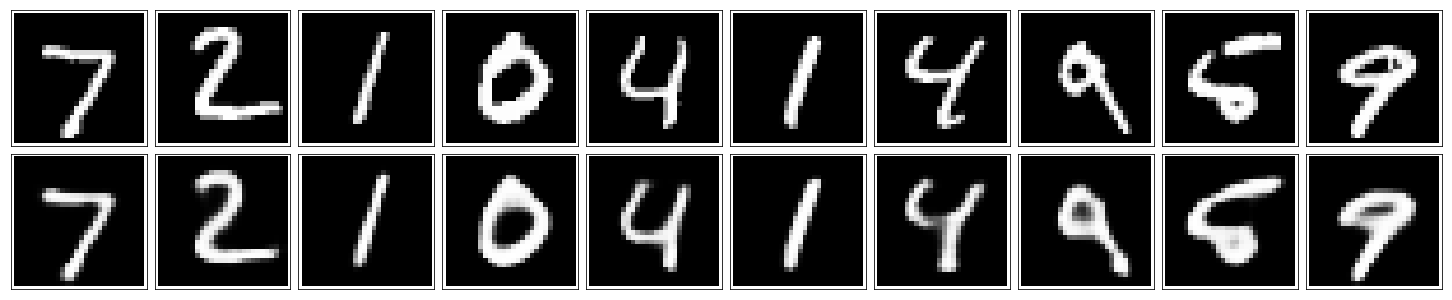

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
reconstructed = sess.run(decoded, feed_dict={input_: in_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


fig.tight_layout(pad=0.1)

In [19]:
sess.close()

## Denoising

As I've mentioned before, autoencoders like the ones you've built so far aren't too useful in practive. However, they can be used to denoise images quite successfully just by training the network on noisy images. We can create the noisy images ourselves by adding Gaussian noise to the training images, then clipping the values to be between 0 and 1. We'll use noisy images as input and the original, clean images as targets. Here's an example of the noisy images I generated and the denoised images.

![Denoising autoencoder](assets/denoising.png)


Since this is a harder problem for the network, we'll want to use deeper convolutional layers here, more feature maps. I suggest something like 32-32-16 for the depths of the convolutional layers in the encoder, and the same depths going backward through the decoder. Otherwise the architecture is the same as before.

> **Exercise:** Build the network for the denoising autoencoder. It's the same as before, but with deeper layers. I suggest 32-32-16 for the depths, but you can play with these numbers, or add more layers.

In [5]:
learning_rate = 0.001
inputs_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='targets')

### Encoder
conv1_maxpool = conv_maxpool(inputs_,16,(3,3),(1,1),(2,2),(2,2))
# Now 14x14x16
conv2_maxpool = conv_maxpool(conv1_maxpool,8,(3,3),(1,1),(2,2),(2,2)) 
# Now 7x7x8
conv3_maxpool = conv_maxpool(conv2_maxpool,8,(3,3),(1,1),(2,2),(2,2))
# Now 4x4x8
encoded = conv3_maxpool
# Now 4x4x8

### Decoder
upsample1_conv = resize_conv(encoded,8,(3,3),(1,1),(7,7))
# Now 7x7x8
upsample2_conv = resize_conv(upsample1_conv,8,(3,3),(1,1),(14,14))
# Now 14x14x8
upsample3_conv = resize_conv(upsample2_conv,16,(3,3),(1,1),(28,28))
# Now 28x28x16
logits = output_layer(upsample3_conv,1,(3,3),(1,1))

# Pass logits through sigmoid to get reconstructed image
decoded = tf.nn.sigmoid(logits)

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=targets_)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [6]:
sess = tf.Session()

In [ ]:
epochs = 100
batch_size = 200
# Set's how much noise we're adding to the MNIST images
noise_factor = 0.5
sess.run(tf.global_variables_initializer())
for e in tqdm.tqdm(range(epochs)):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        # Get images from the batch
        imgs = batch[0].reshape((-1, 28, 28, 1))
        
        # Add random noise to the input images
        noisy_imgs = imgs + noise_factor * np.random.randn(*imgs.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        
        # Noisy images as inputs, original images as targets
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: noisy_imgs,
                                                         targets_: imgs})

    print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

  1%|          | 1/100 [01:23<2:17:20, 83.24s/it]

Epoch: 1/100... Training loss: 0.1877


  2%|▏         | 2/100 [02:46<2:15:57, 83.24s/it]

Epoch: 2/100... Training loss: 0.1731


  3%|▎         | 3/100 [04:09<2:14:39, 83.29s/it]

Epoch: 3/100... Training loss: 0.1518


  4%|▍         | 4/100 [05:32<2:12:41, 82.94s/it]

Epoch: 4/100... Training loss: 0.1526


  5%|▌         | 5/100 [06:53<2:10:39, 82.52s/it]

Epoch: 5/100... Training loss: 0.1567


  6%|▌         | 6/100 [08:16<2:09:38, 82.75s/it]

Epoch: 6/100... Training loss: 0.1474


  7%|▋         | 7/100 [09:38<2:07:56, 82.54s/it]

Epoch: 7/100... Training loss: 0.1428


  8%|▊         | 8/100 [11:00<2:06:16, 82.35s/it]

Epoch: 8/100... Training loss: 0.1504


  9%|▉         | 9/100 [12:22<2:04:31, 82.10s/it]

Epoch: 9/100... Training loss: 0.1438


 10%|█         | 10/100 [13:43<2:02:43, 81.82s/it]

Epoch: 10/100... Training loss: 0.1440


 11%|█         | 11/100 [15:04<2:01:13, 81.72s/it]

Epoch: 11/100... Training loss: 0.1435


 12%|█▏        | 12/100 [16:26<1:59:41, 81.61s/it]

Epoch: 12/100... Training loss: 0.1384


 13%|█▎        | 13/100 [17:47<1:58:02, 81.41s/it]

Epoch: 13/100... Training loss: 0.1366


 14%|█▍        | 14/100 [19:08<1:56:23, 81.21s/it]

Epoch: 14/100... Training loss: 0.1374


 15%|█▌        | 15/100 [20:28<1:54:51, 81.08s/it]

Epoch: 15/100... Training loss: 0.1351


 16%|█▌        | 16/100 [21:50<1:53:46, 81.26s/it]

Epoch: 16/100... Training loss: 0.1394


 17%|█▋        | 17/100 [23:11<1:52:17, 81.18s/it]

Epoch: 17/100... Training loss: 0.1341


 18%|█▊        | 18/100 [24:32<1:50:41, 80.99s/it]

Epoch: 18/100... Training loss: 0.1311


 19%|█▉        | 19/100 [25:52<1:49:04, 80.80s/it]

Epoch: 19/100... Training loss: 0.1325


 20%|██        | 20/100 [27:13<1:47:49, 80.87s/it]

Epoch: 20/100... Training loss: 0.1346


 21%|██        | 21/100 [28:35<1:46:51, 81.15s/it]

Epoch: 21/100... Training loss: 0.1357


 22%|██▏       | 22/100 [29:55<1:45:20, 81.03s/it]

Epoch: 22/100... Training loss: 0.1287


 23%|██▎       | 23/100 [31:16<1:43:59, 81.03s/it]

Epoch: 23/100... Training loss: 0.1353


 24%|██▍       | 24/100 [32:37<1:42:33, 80.96s/it]

Epoch: 24/100... Training loss: 0.1287


 25%|██▌       | 25/100 [33:58<1:40:58, 80.78s/it]

Epoch: 25/100... Training loss: 0.1289


 26%|██▌       | 26/100 [35:18<1:39:27, 80.65s/it]

Epoch: 26/100... Training loss: 0.1291


 27%|██▋       | 27/100 [36:39<1:38:10, 80.69s/it]

Epoch: 27/100... Training loss: 0.1289


 28%|██▊       | 28/100 [37:59<1:36:47, 80.66s/it]

Epoch: 28/100... Training loss: 0.1273


 29%|██▉       | 29/100 [39:21<1:35:40, 80.86s/it]

Epoch: 29/100... Training loss: 0.1283


 30%|███       | 30/100 [40:41<1:34:15, 80.79s/it]

Epoch: 30/100... Training loss: 0.1273


 31%|███       | 31/100 [42:03<1:33:09, 81.01s/it]

Epoch: 31/100... Training loss: 0.1266


 32%|███▏      | 32/100 [43:24<1:31:50, 81.04s/it]

Epoch: 32/100... Training loss: 0.1291


 33%|███▎      | 33/100 [44:46<1:30:55, 81.43s/it]

Epoch: 33/100... Training loss: 0.1255


 34%|███▍      | 34/100 [46:07<1:29:26, 81.31s/it]

Epoch: 34/100... Training loss: 0.1216


 35%|███▌      | 35/100 [47:28<1:27:46, 81.03s/it]

Epoch: 35/100... Training loss: 0.1255


 36%|███▌      | 36/100 [48:48<1:26:10, 80.79s/it]

Epoch: 36/100... Training loss: 0.1263


 37%|███▋      | 37/100 [50:09<1:24:52, 80.83s/it]

Epoch: 37/100... Training loss: 0.1265


 38%|███▊      | 38/100 [51:31<1:23:48, 81.10s/it]

Epoch: 38/100... Training loss: 0.1248


 39%|███▉      | 39/100 [52:53<1:22:53, 81.53s/it]

Epoch: 39/100... Training loss: 0.1248


 40%|████      | 40/100 [54:15<1:21:37, 81.63s/it]

Epoch: 40/100... Training loss: 0.1223


 41%|████      | 41/100 [55:35<1:19:39, 81.01s/it]

Epoch: 41/100... Training loss: 0.1272


 42%|████▏     | 42/100 [56:55<1:18:11, 80.89s/it]

Epoch: 42/100... Training loss: 0.1230


 43%|████▎     | 43/100 [58:14<1:16:09, 80.17s/it]

Epoch: 43/100... Training loss: 0.1270


 44%|████▍     | 44/100 [59:32<1:14:21, 79.67s/it]

Epoch: 44/100... Training loss: 0.1203


 45%|████▌     | 45/100 [1:00:51<1:12:53, 79.52s/it]

Epoch: 45/100... Training loss: 0.1221


 46%|████▌     | 46/100 [1:02:10<1:11:23, 79.32s/it]

Epoch: 46/100... Training loss: 0.1218


 47%|████▋     | 47/100 [1:03:30<1:10:04, 79.34s/it]

Epoch: 47/100... Training loss: 0.1222


 48%|████▊     | 48/100 [1:04:51<1:09:19, 79.99s/it]

Epoch: 48/100... Training loss: 0.1234


 49%|████▉     | 49/100 [1:06:15<1:09:04, 81.26s/it]

Epoch: 49/100... Training loss: 0.1241


 50%|█████     | 50/100 [1:07:37<1:07:52, 81.46s/it]

Epoch: 50/100... Training loss: 0.1243


 51%|█████     | 51/100 [1:09:05<1:08:11, 83.49s/it]

Epoch: 51/100... Training loss: 0.1237


 52%|█████▏    | 52/100 [1:10:30<1:07:01, 83.78s/it]

Epoch: 52/100... Training loss: 0.1265


 53%|█████▎    | 53/100 [1:11:50<1:04:52, 82.81s/it]

Epoch: 53/100... Training loss: 0.1192


 54%|█████▍    | 54/100 [1:13:06<1:01:46, 80.57s/it]

Epoch: 54/100... Training loss: 0.1205


 55%|█████▌    | 55/100 [1:14:21<59:17, 79.05s/it]  

Epoch: 55/100... Training loss: 0.1271


 56%|█████▌    | 56/100 [1:15:41<58:05, 79.21s/it]

Epoch: 56/100... Training loss: 0.1227


 57%|█████▋    | 57/100 [1:17:06<58:06, 81.07s/it]

Epoch: 57/100... Training loss: 0.1234


 58%|█████▊    | 58/100 [1:18:33<57:52, 82.67s/it]

Epoch: 58/100... Training loss: 0.1211


 59%|█████▉    | 59/100 [1:19:55<56:27, 82.62s/it]

Epoch: 59/100... Training loss: 0.1188


 60%|██████    | 60/100 [1:21:17<55:00, 82.50s/it]

Epoch: 60/100... Training loss: 0.1212


 61%|██████    | 61/100 [1:22:33<52:17, 80.46s/it]

Epoch: 61/100... Training loss: 0.1191


 62%|██████▏   | 62/100 [1:23:48<49:50, 78.70s/it]

Epoch: 62/100... Training loss: 0.1213


 63%|██████▎   | 63/100 [1:25:02<47:45, 77.44s/it]

Epoch: 63/100... Training loss: 0.1204


 64%|██████▍   | 64/100 [1:26:17<45:58, 76.63s/it]

Epoch: 64/100... Training loss: 0.1199


 65%|██████▌   | 65/100 [1:27:31<44:14, 75.85s/it]

Epoch: 65/100... Training loss: 0.1187


 66%|██████▌   | 66/100 [1:28:46<42:48, 75.53s/it]

Epoch: 66/100... Training loss: 0.1221


 67%|██████▋   | 67/100 [1:30:00<41:20, 75.15s/it]

Epoch: 67/100... Training loss: 0.1232


 68%|██████▊   | 68/100 [1:31:15<40:00, 75.02s/it]

Epoch: 68/100... Training loss: 0.1202


 69%|██████▉   | 69/100 [1:32:29<38:36, 74.71s/it]

Epoch: 69/100... Training loss: 0.1203


 70%|███████   | 70/100 [1:33:43<37:20, 74.67s/it]

Epoch: 70/100... Training loss: 0.1223


 71%|███████   | 71/100 [1:34:57<35:58, 74.44s/it]

Epoch: 71/100... Training loss: 0.1220


 72%|███████▏  | 72/100 [1:36:12<34:45, 74.47s/it]

Epoch: 72/100... Training loss: 0.1181


 73%|███████▎  | 73/100 [1:37:26<33:29, 74.41s/it]

Epoch: 73/100... Training loss: 0.1202


 74%|███████▍  | 74/100 [1:38:41<32:15, 74.43s/it]

Epoch: 74/100... Training loss: 0.1199


 75%|███████▌  | 75/100 [1:39:55<30:59, 74.36s/it]

Epoch: 75/100... Training loss: 0.1206


 76%|███████▌  | 76/100 [1:41:09<29:44, 74.36s/it]

Epoch: 76/100... Training loss: 0.1182


 77%|███████▋  | 77/100 [1:42:23<28:26, 74.21s/it]

Epoch: 77/100... Training loss: 0.1253


 78%|███████▊  | 78/100 [1:43:38<27:15, 74.35s/it]

Epoch: 78/100... Training loss: 0.1206


 79%|███████▉  | 79/100 [1:44:52<26:00, 74.31s/it]

Epoch: 79/100... Training loss: 0.1209


 80%|████████  | 80/100 [1:46:07<24:52, 74.64s/it]

Epoch: 80/100... Training loss: 0.1194


 81%|████████  | 81/100 [1:47:21<23:35, 74.52s/it]

Epoch: 81/100... Training loss: 0.1211


 82%|████████▏ | 82/100 [1:48:36<22:21, 74.51s/it]

Epoch: 82/100... Training loss: 0.1210


 83%|████████▎ | 83/100 [1:49:51<21:07, 74.54s/it]

Epoch: 83/100... Training loss: 0.1224


 84%|████████▍ | 84/100 [1:51:05<19:53, 74.58s/it]

Epoch: 84/100... Training loss: 0.1221


 85%|████████▌ | 85/100 [1:52:19<18:36, 74.46s/it]

Epoch: 85/100... Training loss: 0.1205


 86%|████████▌ | 86/100 [1:53:33<17:20, 74.30s/it]

Epoch: 86/100... Training loss: 0.1187


 87%|████████▋ | 87/100 [1:54:47<16:04, 74.20s/it]

Epoch: 87/100... Training loss: 0.1154


 88%|████████▊ | 88/100 [1:56:01<14:50, 74.18s/it]

Epoch: 88/100... Training loss: 0.1189


 89%|████████▉ | 89/100 [1:57:16<13:36, 74.20s/it]

Epoch: 89/100... Training loss: 0.1172


 90%|█████████ | 90/100 [1:58:30<12:22, 74.22s/it]

Epoch: 90/100... Training loss: 0.1185


 91%|█████████ | 91/100 [1:59:44<11:07, 74.19s/it]

Epoch: 91/100... Training loss: 0.1183


 92%|█████████▏| 92/100 [2:00:58<09:53, 74.19s/it]

Epoch: 92/100... Training loss: 0.1165


 93%|█████████▎| 93/100 [2:02:13<08:39, 74.26s/it]

Epoch: 93/100... Training loss: 0.1173


 94%|█████████▍| 94/100 [2:03:28<07:26, 74.44s/it]

Epoch: 94/100... Training loss: 0.1185


 95%|█████████▌| 95/100 [2:04:42<06:11, 74.29s/it]

Epoch: 95/100... Training loss: 0.1154


 96%|█████████▌| 96/100 [2:05:56<04:57, 74.29s/it]

Epoch: 96/100... Training loss: 0.1153


 97%|█████████▋| 97/100 [2:07:10<03:42, 74.30s/it]

Epoch: 97/100... Training loss: 0.1181


 98%|█████████▊| 98/100 [2:08:25<02:28, 74.48s/it]

Epoch: 98/100... Training loss: 0.1201


 99%|█████████▉| 99/100 [2:09:40<01:14, 74.57s/it]

Epoch: 99/100... Training loss: 0.1224


100%|██████████| 100/100 [2:10:54<00:00, 74.40s/it]

Epoch: 100/100... Training loss: 0.1214


## Checking out the performance

Here I'm adding noise to the test images and passing them through the autoencoder. It does a suprisingly great job of removing the noise, even though it's sometimes difficult to tell what the original number is.

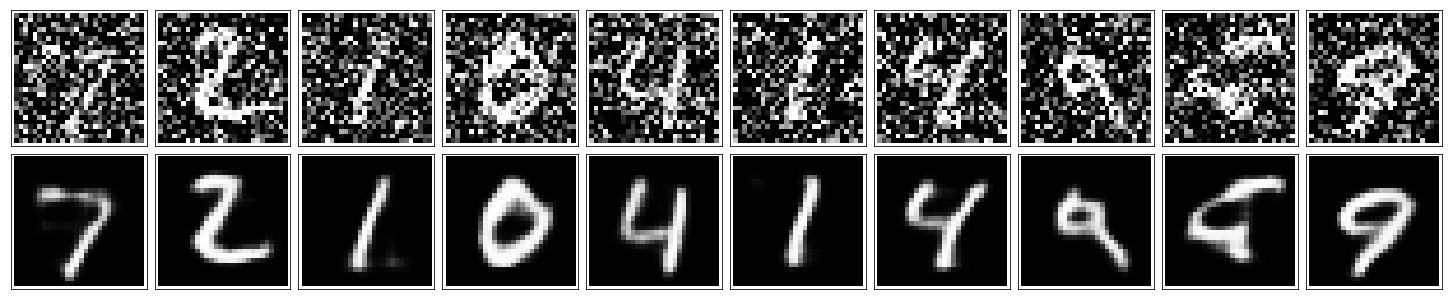

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
noisy_imgs = in_imgs + noise_factor * np.random.randn(*in_imgs.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

reconstructed = sess.run(decoded, feed_dict={inputs_: noisy_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([noisy_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)